## Simple XGBoost tutorial


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

## How to use XGBoost in RecSys?

## Hint: reranking and hybridization

### Steps:
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

## Dummy example

Load Data

In [36]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample


URM_all = data_loaded.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.8)

ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_year, Value range: 6.00E+00 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




### Let's select the recommendations to use to train XGBoost

Several options are possible:
- Take the best recommender and select, say, the top-100 recommended items
- Take multiple recommenders and use the union of their recommendations
- ...

In this example a single model will be used to select the candidate user-item interactions to use for XGBoost

In [ ]:
from Recommenders.Recommender_import_list import *

candidate_generator_recommender = ItemKNNCFRecommender(URM_train)
candidate_generator_recommender.fit()

## Build the dataframe with the predictions

Creating dataframes can be quite computationally expensive. Never use "append" or iteratively concatenate new elements when you have to run a significant number of iterations, it will take forever. Initialize instead the dimension you want.

In [ ]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [39]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
69873,NaN
69874,NaN
69875,NaN


In [40]:
cutoff = 30

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69878/69878 [00:44<00:00, 1556.72it/s]


In [41]:
training_dataframe

,ItemID
UserID,
0,"[18, 94, 91, 11, 175, 93, 74, 85, 26, 84, 82, ..."
1,"[31, 1302, 1283, 96, 37, 32, 1304, 1429, 141, ..."
2,"[284, 296, 64, 1204, 60, 798, 279, 461, 793, 8..."
3,"[75, 93, 94, 26, 3, 175, 84, 1418, 1, 83, 78, ..."
4,"[164, 1073, 176, 1122, 44, 219, 218, 1554, 100..."
...,...
69873,"[64, 793, 821, 982, 968, 1882, 279, 958, 864, ..."
69874,"[468, 192, 19, 101, 140, 177, 259, 195, 213, 1..."
69875,"[164, 218, 227, 34, 219, 44, 165, 1475, 244, 4..."


### Let's transform the dataframe so that we have one recommendation per row

In [42]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,18
0,94
0,91
0,11
0,175
...,...
69877,1093
69877,34
69877,190


### We should add the target column, which is the correct recommendation as contained in the validation data

In [43]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,4
1,0,8
2,0,18
3,0,19
4,1,31
...,...,...
1600004,69877,14
1600005,69877,153
1600006,69877,185
1600007,69877,518


In [44]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,18,both
1,0,94,left_only
2,0,91,left_only
3,0,11,left_only
4,0,175,left_only
...,...,...,...
2096335,69877,1093,left_only
2096336,69877,34,left_only
2096337,69877,190,left_only
2096338,69877,505,left_only


In [45]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,18,True
1,0,94,False
2,0,91,False
3,0,11,False
4,0,175,False
...,...,...,...
2096335,69877,1093,False
2096336,69877,34,False
2096337,69877,190,False
2096338,69877,505,False


## Now let's add some features. For example, the prediction of other algorithms

This may take some time so it is a good idea to save this data and load it instead of calculating the scores every time.

In [ ]:
topPop = TopPop(URM_train)
topPop.fit()

p3alpha = P3alphaRecommender(URM_train)
p3alpha.fit()

slimbpr = SLIM_BPR_Cython(URM_train)
slimbpr.fit()


other_algorithms = {
    "TopPop": topPop,
    "P3alpha": p3alpha,
    "SLIM_BPR": slimbpr,
}


In [47]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69878/69878 [58:02<00:00, 20.07it/s]


,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR
0,0,18,True,14961.0,0.326508,1.591030
1,0,94,False,12595.0,0.315118,1.465367
2,0,91,False,12320.0,0.257842,1.422632
3,0,11,False,15200.0,0.286878,1.426761
4,0,175,False,18645.0,0.368709,1.614257
...,...,...,...,...,...,...
2096335,69877,1093,False,9845.0,0.000000,0.663948
2096336,69877,34,False,12743.0,0.023613,0.999950
2096337,69877,190,False,5981.0,0.000000,0.513428
2096338,69877,505,False,6715.0,0.009910,0.598634


## The popularity of the item, the user activity etc..

In [48]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity
0,0,18,True,14961.0,0.326508,1.591030,14961
1,0,94,False,12595.0,0.315118,1.465367,12595
2,0,91,False,12320.0,0.257842,1.422632,12320
3,0,11,False,15200.0,0.286878,1.426761,15200
4,0,175,False,18645.0,0.368709,1.614257,18645
...,...,...,...,...,...,...,...
2096335,69877,1093,False,9845.0,0.000000,0.663948,9845
2096336,69877,34,False,12743.0,0.023613,0.999950,12743
2096337,69877,190,False,5981.0,0.000000,0.513428,5981
2096338,69877,505,False,6715.0,0.009910,0.598634,6715


## Or the profile length

In [49]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,18,True,14961.0,0.326508,1.591030,14961,14
1,0,94,False,12595.0,0.315118,1.465367,12595,14
2,0,91,False,12320.0,0.257842,1.422632,12320,14
3,0,11,False,15200.0,0.286878,1.426761,15200,14
4,0,175,False,18645.0,0.368709,1.614257,18645,14
...,...,...,...,...,...,...,...,...
2096335,69877,1093,False,9845.0,0.000000,0.663948,9845,35
2096336,69877,34,False,12743.0,0.023613,0.999950,12743,35
2096337,69877,190,False,5981.0,0.000000,0.513428,5981,35
2096338,69877,505,False,6715.0,0.009910,0.598634,6715,35


## The same can be done with item features

It is better in this case to first create a sparse matrix replicating the rows needed and ten transform it into a sparse dataframe

**WARNING** dataframes are not sparse structures and this may cause the memory requirements to explode

In [50]:
features_df = pd.DataFrame.sparse.from_spmatrix(ICM_genres)
features_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10677,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

,ItemID,UserID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len,0,1,...,10,11,12,13,14,15,16,17,18,19
0,0,56423,False,1555.0,0.000000,0.032327,1555,16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,False,9561.0,0.498749,2.640705,9561,25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,18,False,9561.0,0.283760,2.195526,9561,26,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,41,True,9561.0,0.332952,2.338053,9561,27,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,50,True,9561.0,0.220238,1.604507,9561,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096335,9718,21248,False,10.0,0.000000,0.008116,10,104,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2096336,9718,27120,False,10.0,0.000000,0.000507,10,9,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2096337,9718,60873,False,10.0,0.000000,0.001849,10,39,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2096338,9988,24050,False,12.0,0.044247,0.000360,12,15,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not

In [52]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,ItemID,UserID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len,0,1,...,10,11,12,13,14,15,16,17,18,19
0,18,0,True,14961.0,0.326508,1.591030,14961,14,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,11,0,False,15200.0,0.286878,1.426761,15200,14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,95,0,False,12207.0,0.255629,1.316224,12207,14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78,0,False,10246.0,0.144923,1.196503,10246,14,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,338,0,False,6678.0,0.072712,0.739263,6678,14,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096335,241,69877,False,7725.0,0.000000,0.677784,7725,35,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096336,397,69877,False,6318.0,0.011357,0.672592,6318,35,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096337,235,69877,False,13495.0,0.051978,1.107446,13495,35,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096338,196,69877,False,10122.0,0.008347,1.027131,10122,35,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user (30) all groups have the same length.

In [53]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [54]:
from xgboost import XGBRanker

In [55]:
# this goes into optuna for hyperparameters tuning
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [56]:
# this goes inside CV loop
# Create new split
# Create new dataset with features
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=False, eval_metric=None, feature_types=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
          max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=50, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, ...)

### Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will ten need to rank as we do in any other recommender model.

### Important: In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

In [57]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.5575064 ,  0.5647441 ,  0.77526385,  0.2576419 , -0.18917976,
       -0.14601524,  0.46377534, -0.15219668,  0.5399777 , -0.12915118,
       -0.16812514,  0.46943876,  0.83414567, -0.19775411,  0.9705955 ,
        0.17818022,  0.78721637,  0.31016684,  0.4934019 ,  0.19676009,
        0.51816803, -0.20890543,  0.21673968,  0.4726    ,  0.40746757,
        0.34033227, -0.13198298,  0.43841097, -0.14032924, -0.20562884],
      dtype=float32)

### We can have a look to the feature importance to assess which are the most informative ones

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

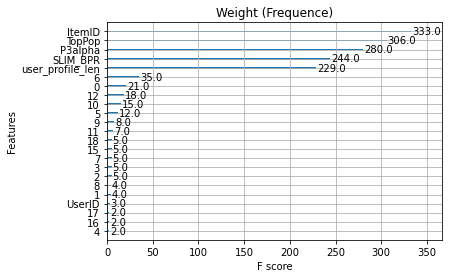

In [58]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

### Note, here ItemID and UserID are provided as integers, meaning that XGBoost will use them as any integer number and may split user groups according to whether their ID is < or > of a certain value. This makes no sense of course because the IDs are not ordinal, they are categorical and the specific numerical value of an IDs has no relation with the semantics of the problem. 

How to address this? 
- Use one-hot-encoded values -> drawback, the number of columns becomes very large
- Use the native "Categorical" data type -> drawback, it is still experimental and may not work very well
- Use another representation of the IDs, such as target encoding -> drawback, some further processing is needed and no teaching material is provided on this

In [59]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [64]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=True, eval_metric=None, feature_types=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
          max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=50, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [67]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.73390704,  0.62681353,  0.87409973,  0.3426147 ,  0.01065741,
       -0.01489185,  0.5993317 ,  0.04778361,  0.9248954 ,  0.00530966,
        0.01065741,  0.58684003,  1.045459  ,  0.00530966,  0.89649963,
        0.21467504,  0.8267461 ,  0.5483578 ,  0.627125  ,  0.23716187,
        0.5483578 ,  0.01065741,  0.2167772 ,  0.627125  ,  0.21841489,
        0.5483578 ,  0.02103525,  0.42995113,  0.00530966,  0.01065741],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

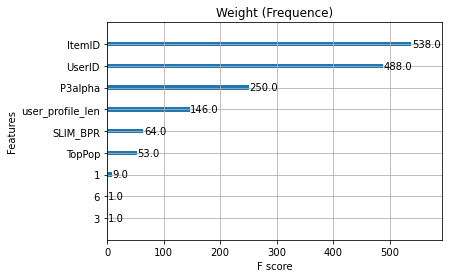

In [68]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

### How to perform hyperparameter tuning?
The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.

In [ ]:
0.1983457194562848
0.19940436448221285
0.19865313128989975 